In [0]:
pip install transformers

# **BERT 톺아보기**
BERT(이하 버트, Bidirectional Encoder Representations from Trsnaformer) 모델은 18년 10월에 논문이 공개된 구글의 새로운 Language Representation Model 이다. 

 기존의 ELMo 모델은 특징(Feature) 기반 전이학습으로, 단어(토큰)에 대한 특징 벡터를 훈련하는 방법이다. 이와는 달리 BERT는 파인 튜닝(Fine-Tuning) 기반 전이학습으로 이루어진다. 즉, 
 1. **(Wikipedia와 같은) 큰 텍스트 코퍼스를 이용해 Pre-training한 모델에 기반해**
 2. **실제 자연 언어 처리 태스크에 적용**  
 
 하는 방식으로 이루어진다.  
 
   
 본 Colab Notebook에서는 BERT가 진행되는 순서를 찬찬히 설명하고, Pre-training을 직접해보는 실습까지 담았다. 순서는 다음과 같다.


**- BERT 따라가기**
1. Input Embeddings
2. Pre-training
3. Fine-tuning  

**- 실습단계: Next Sentence Prediction 구현해보기**

# 1. Model Architecture

본격적으로 들어가기 전에 모델 구조를 간단히 보도록 하자. 

- BERT는 크기에 따라 다른 구조를 제공한다.
- BERT_base : L=12, H=768, A=12, Total Parameters = 110M
- BERT_large : L=24, H=1024, A=16, Total Parameters = 340M
- L : transformer block의 layer 수, H : hidden size, A : self-attention heads 수, feed-forward/filter size = 4H

<p align="center">
<img src="![image.png]()https://mino-park7.github.io/images/2019/02/%EA%B7%B8%EB%A6%BC8-ablation-result3.png" width = 600px align="center">  </p>  
Pre-trained 모델도 종류별로 있어서, 추가로 이들의 Accuracy 정도도 확인해 볼 수 있다.
<p align="center">
<img src="https://mino-park7.github.io/images/2019/02/%EA%B7%B8%EB%A6%BC8-ablation-result3.png" width = 300px align="center">  </p>

In [0]:
#모델을 위해 필요한 라이브러리 import하기
import torch
from transformers import BertTokenizer, BertModel
import logging
import matplotlib.pyplot as plt
% matplotlib inline

# pre-trained model tokenizer 호출하기
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# 2. Input Embeddings

**들어가기 전에..**  
문장을 구성하기 위해 Input에 어떤 정보를 넣는게 좋을까?  
문장들의 Token들과 이에 관한 문장 안의 Token들의 위치 정보나, 문장과 문장 간의 정보를 나타내는 정보들이 들어갈 것이다.   


**들어가기**  
BERT에서는 Input에는 어떠한 정보를 넣는지 살펴보자.  
Input을 만들 때 문장 자체의 정보를 삽입하는 것이므로 모든 조건이 고려되야만 할 것이다.  BERT에는 3가지 정보가 들어간다.  
  

<p align="center">
<img src="https://user-images.githubusercontent.com/1250095/50039788-8e4e8a00-007b-11e9-9747-8e29fbbea0b3.png" width = 800px align="center">  </p>  


  

  
Embedding을 위한 Input에는 BookCorpus와 Wikipedia 문장들을 포함해 총 3.3억개의 단어를 바탕으로 임베딩이 진행되었다.  
**Input Embedding = Token Embedding + Segment Embedding + Position Embedding**이며, 언어의 특성을 파악하기 위한 조건들을 바탕으로 정해졌다. 각각의 Embedding을 하나하나 살펴보자. 이해를 위해 다음과 같은 문장을 토대로 설명하고자 한다.  
시작하기 전에 적용할 텍스트 2개를 살펴보자.

In [30]:
# "bank"을 여러 token으로 가지고 있는 문장을 밑 실습에서 사용하게 된다.
text = "After stealing money from the bank vault, the bank robber was seen " \
       "fishing on the Mississippi river bank."

# 문장의 시작을 의미하는 [CLS]와 문장의 끝(분리)을 나타내는 [SEP]을 추가해준다.
marked_text = "[CLS] " + text + " [SEP]"
print(marked_text)

[CLS] After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank. [SEP]


## 2.1 Token Embedding
Token Embedding은 문장을 토큰으로 나누는 과정을 말한다. 여기서는 Word Piece Model을 이용하여 구현하였다. 이 모델은 제한적인 vocabulary units, 정확히는 단어를 표현할 수 있는 subwords units 으로 모든 단어를 표현한다.  
다음의 적용된 예시를 보도록 하자. 문장을 다음의 요소들로 나눈다면 이 유닛들은 의미를 보존하면서 재활용 될 수 있다.

```
공연은 끝났어 -> ['공연-' + '-은' + '끝-' + '-났어']
공연을 끝냈어 -> ['공연-' + '-을' + '끝-' + '-냈어']
개막을 해냈어 -> ['개막-' + '-을' + '해-' + '-냈어']
```

위에 예제로 사용된 문장과 달리 문장이 복잡한 상황을 살펴보자.  marked_text_a와 marked_text_b에 적용한 코드는 다음과 같다.


In [31]:
raw_text_a = "Seahorses dreamed about word embeddings and artificial intelligence"
raw_text_b = "Seahorse is a smart animal"
marked_text_a = "[CLS] " + raw_text_a + " [SEP]"
marked_text_b = "[CLS] " + raw_text_b + " [SEP]"
print(marked_text_a)
print(marked_text_b)

[CLS] Seahorses dreamed about word embeddings and artificial intelligence [SEP]
[CLS] Seahorse is a smart animal [SEP]


In [32]:
tokens_a = tokenizer.tokenize(marked_text_a)
tokens_b = tokenizer.tokenize(marked_text_b)
print(marked_text_a)
print(tokens_a)
print(marked_text_b)
print(tokens_b)

[CLS] Seahorses dreamed about word embeddings and artificial intelligence [SEP]
['[CLS]', 'sea', '##horse', '##s', 'dreamed', 'about', 'word', 'em', '##bed', '##ding', '##s', 'and', 'artificial', 'intelligence', '[SEP]']
[CLS] Seahorse is a smart animal [SEP]
['[CLS]', 'sea', '##horse', 'is', 'a', 'smart', 'animal', '[SEP]']


이와 같이 Token들로 나누어진 걸 볼 수 있다. Token들 중에 간간히 나오는 ## 표시는 이 단어는 어떤 단어의 일부 즉, subword라는 뜻을 말한다. Bert에서는 단어를 검색하는 방식으로 진행되는데, 전체 단어가 BERT vocab에 없으면 vocab에서 찾을 때까지 철자 하나씩까지도 쪼개는 방식으로 진행된다.  
여기서 나온 Seahorse는 본 단어에서 Sea와 ##horse(2개의 Subword들)로 쪼개진 것을 알 수 있다.   

우리가 적용한 코드는 이렇게 적용된다.

In [33]:
# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)
print(tokenized_text)

['[CLS]', 'after', 'stealing', 'money', 'from', 'the', 'bank', 'vault', ',', 'the', 'bank', 'robber', 'was', 'seen', 'fishing', 'on', 'the', 'mississippi', 'river', 'bank', '.', '[SEP]']


In [34]:
# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
after         2,044
stealing     11,065
money         2,769
from          2,013
the           1,996
bank          2,924
vault        11,632
,             1,010
the           1,996
bank          2,924
robber       27,307
was           2,001
seen          2,464
fishing       5,645
on            2,006
the           1,996
mississippi   5,900
river         2,314
bank          2,924
.             1,012
[SEP]           102


## 2.2 Segment Embedding
Segment Embedding에서는 문장과 문장간의 관계를 나타낸다. 문장이 두개로 이어진 Input에서는 Segment ID는 첫 문장에는 0, 다음 문장은 1로 준다. 문장이 하나인 경우에는 Segment ID를 모두 1로 준다.


In [35]:
#한 문장이  22개의 토큰으로 이루어져 있으므로, 모든 token에는 1의 값이 부여된다.
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [36]:
raw_text_b = "Seahorse is a smart animal"
marked_text_b = raw_text_b + " [SEP]"
tokens_b = tokenizer.tokenize(marked_text_b)
print(tokens_b)

tokens = []
input_type_ids = []

#두 문장을 가지고 있으므로 앞에는 0 뒤에는 1을 붙여준다.
for token in tokens_a:
    tokens.append(token)
    input_type_ids.append(0)

if tokens_b:
    for token in tokens_b:
        tokens.append(token)
        input_type_ids.append(1)
        
print("tokens:", tokens)   
print("type_ids:", input_type_ids)

['sea', '##horse', 'is', 'a', 'smart', 'animal', '[SEP]']
tokens: ['[CLS]', 'sea', '##horse', '##s', 'dreamed', 'about', 'word', 'em', '##bed', '##ding', '##s', 'and', 'artificial', 'intelligence', '[SEP]', 'sea', '##horse', 'is', 'a', 'smart', 'animal', '[SEP]']
type_ids: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]


## 2.3 Position Embedding
Position Embedding에서는 한 문장 내 특정 토큰의 순서를 보여준다.  
다음과 같은 코드를 이용해 위치를 token화 할 수 있다.

In [37]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


총 세가지 Embedding 정보를 이용해 Input Data를 형성하였고, 여기에 더해 Layer Normalization과 DropOut의 기법도 사용되었다.  
이렇게 나온 Input Embedding은 Pre-training에 사용된다.

**추가** 기존 임베딩 VS BERT 임베딩
- 기존 임베딩은 문맥에 상관없이 같은 단어면 항상 같은 임베딩
- Bert 임베딩은 문맥에 따라 다른 임베딩 양상을 보인다. 동음이의어뿐만 아니라, 문맥이 달라지면 같은 의미의 단어도 임베딩이 달라진다. 

# 2. Pre-training

<img src="https://blog.pingpong.us/images/2020.01.03.ml-transformer/transformer.png" width = 250px align="right">  

주어진 Embedding된 Input들을 토대로 사전학습을 어떻게 하는지 알아보자.  
BERT는 Pre-training을 위해 성능이 높은 *Transformer*구조를 참고하였는데, 왼쪽에 나온 Transformer 모델 중 왼쪽 Encoder 블록만을 취해 적용하는 방법을 택하였다. 이를 바탕으로 Input을 어떤 방식으로 학습하는지 알아보자.
BERT는 총 두가지 방법을 통해 이루어진다.  
  

## 2.1 MLM (Masked Language Model)
: input에서 무작위하게 몇개의 token을 mask(가려준다)해준다. Input 전체와 mask된 token을 한번에 Transformer encoder에 넣게되면  
Masked된 Token을 맞추는 일종의 빈칸채우기와 같은 train을 시작한다.다음 예시를 보며 어떻게 변형하는지 살펴보자.

  

**예시**
다음과 같은 문장을 넣는다고 가정해보자.  
All good things which exist are the fruits of originality.
```
<Deeply Bidirectional> 
    All good things which [MASK] are the fruits of originality.
    All good [MASK] which exist are the fruits of originality.
    All good things which exist are the [MASK] of originality.
    All [MASK] things which exist are the fruits of originality.

<Left to Right>
    All
    All good
    All good things
    All good things which
        ...

<Right to Left>
                                                    originality
                                                 of originality
                                          fruits of originality
                                      the fruits of originality
                                        ...
```


Input의 15% 단어들을 뽑아 학습하면서, 전체 문장의 특성의 확인이 가능해진다. 이러한 Deeply Bidirectional 학습 방식은 기존의 한 방향으로만 작용하는 left-to-right와 right-to-left의 방식과 다르게 자유롭게 문장 안에서의 학습이 가능하다.
  

## 2.2 Next Language Prediction  
: 간단하게, 두 문장을 pre-training시에 같이 넣어줘, 입력값으로 들어간 두 문장이 이어진 문장인지,  
아니면 관계없는 문장인지를 예측하는 binary classification task를 수행한다.
  

**예시** 어떤 문장이 다음에 나타날 수 있는지 예측해보자.


```
Input = [CLS] The man went to [MASK] store [SEP] He bought a gallon [MASK] milk [END]
Label = IsNext

Input = [CLS] The man went to the store [SEP] Penguin [MASK] are flight ##less birds [END]
Label = NotNext
```

pre-training시에는 50:50 비율로 실제로 이어지는 두 문장과 랜덤하게 추출된 두 문장을 넣어줘서 BERT가 맞추게 시킨다. 이러한 task는 실제 Natural Language Inference와 같은 task를 수행할 때 도움이 된다.


# 3. Fine-tuning

Pre-training을 끝내게 된다면, Fine-tuning에서는 모델을 바탕으로 특정 문제를 해결하는 task들을 하게 된다.  
작업에 따라 다른 방향과 모델로 Tuning이 이루어지며, Task 종류는 다음과 같다.  

<p align = "center">
<img src="https://mino-park7.github.io/images/2019/02/%EA%B7%B8%EB%A6%BC4-bert-experiment-result.png" width =700px align="center"></p>

- Text Similarity: 두 발화(문장)가 같은 의미인지 구분하는 binary classification 문제를 말한다. 
- Word Similarity: 문장 안에 있는 여러 개의 동일한 단어가 같은 의미인지 구분하는 분류 문제를 말한다.
- Reply Matching: 두 발화가 자유럽게 이어지는지 이어지는지 구분하는 binary classification 문제를 말한다.
- Intent Classification:여러 턴의 발화들이 주어졌을 때, 사전에 정의된 답변 class 중 다음에 올 수 있는 답변을 예측하는 multi-class classification 문제를 말한다. 

#### 밑 실습에는 Pre-trained BERT 모델을 이용해 문장을 fine-tuning 학습시켜 Word Similarity Task을 수행한다.


# 4. BERT 모델을 이용해 단어의 유사성 체크해보기: Pre-trained Model 활용해보기

Pre-trained model을 통해 문장을 학습시켜 보자.
먼저 해당하는 Input을 Pytorch Tensor로 변환하는 작업이 필요하다.

In [0]:
# 입력값들을 모두 Model에 들어갈 Tensor(tokens_tensors, segments_tensors)로 만들어준다.
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

#### Pretrained Model 살펴보기
그리고 우리가 사용할 Pre-trained Bert를 꺼내본다.

In [39]:
#pre-trained model 부르기
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True,
                                  )

#Forward만 행하는 "evaluation" 모드로 변경해준다.
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [0]:
# 입력값을 BERT 모델을 넣어준다.
with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]

#### Encoded_layer 분석하기

In [41]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 22
Number of hidden units: 768


현재 모델인 Encoded_layers의 구조를 살펴보자. 

1) layer 개수 : len(encoded_layers) # 12개

2) batch 개수 : len(encoded_layers[0]) # 하나의 문장

3) 단어/토큰 개수 :  len(encoded_layers[0][0]) # batch 1개인 하나의 문장에 있는 22개의 토큰

4) 은닉 상태 차원(hidden units/features) : len(encoded_layers[0][0][0]) # 768개의 features

총 202,752개의 값들로 input으로 넣은 하나의 문장을 표현한다.  

Encoded_layer에 존재하는 layer와 토큰 값들을 표로 살펴보자.

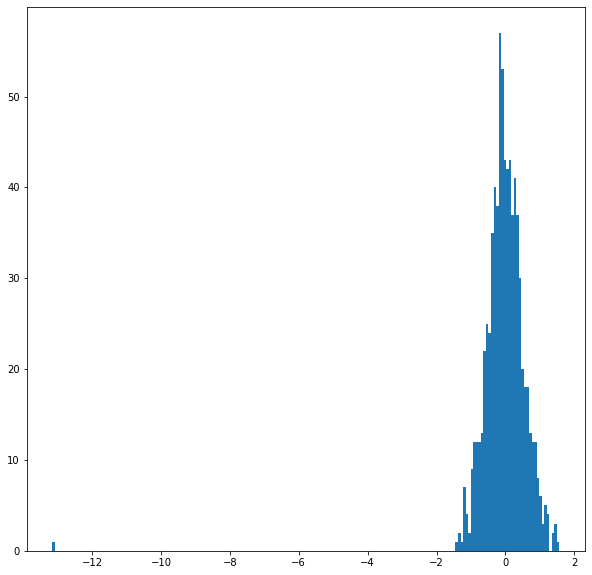

In [42]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# vec정보 즉,하나의 tensor로 합쳐진 정보를 분포에 나타내본다.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

표를 보면 모든 layer들과 토큰 값들은 비슷한데, 대부분의 값들은 [-2,2] 값 사이에 존재함을 알 수 있다.  
몇몇의 값들은 -10이하로 존재함을 볼 수 있다.  

현재의 모델은 layer기준으로 만들어졌지만, 우리는 token으로 묶여야 하므로 차원수를 조정해줘야 한다.

Embedding layer의 차원 정보를 변환해주기로 한다.  
현재 차원:

`[# layers, # batches, # tokens, # features]`

바꾸고자 하는 차원:

`[# tokens, # layers, # features]`

첫번째 차원을 보기로 한다.

In [43]:
# Python tuple로 되어있고,
print('      Type of hidden_states: ', type(hidden_states))

# 각 layer당 torch tensor 개수를 보여준다.
print('Tensor shape for each layer: ', hidden_states[0].size())

      Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 22, 768])


In [44]:
# 모든 Embedding layer를 쌓아준다.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 22, 768])

In [45]:
# batch 정보를 제거해준다..
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 22, 768])

In [46]:
# 0(layer 정보)과 1차원(token 정보)를 추가 조정해준다.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([22, 13, 768])

#### Word Vectors

Word Vector를 두가지 방법으로 만들어보자.
1. 4개의 레이어로 나눠서 만들어보기  

각 vector당  `4x768=3072` 를 가지게 된다.

In [47]:
# token_vecs_cat 정보를 토큰 vector 정보를 저장해준다. [22 x 3,072]
token_vecs_cat = []

# `token_embeddings`에는 총 [22 x 12 x 768] tensor가 존재한다.
# `token`에는 [12 x 768] tensor가 있다.
for token in token_embeddings:
    #torch.cat로 4개의 layer들로 나누어준다.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 22 x 3072


2. four layer 값들을 다 합치기

In [48]:
#token_vecs_sum 정보를 토큰 vector 정보를 저장해준다 [22 x 768]
token_vecs_sum = []

# `token_embeddings`에는 총 [22 x 12 x 768] tensor가 존재한다.
# `token`에는 [12 x 768] tensor가 있다.
for token in token_embeddings:
    #위에는 4개로 나누지만, 여기서는 1개로 합친다.
    sum_vec = torch.sum(token[-4:], dim=0)
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 22 x 768


#### Sentence Vectors

하나 문장을 하나의 vector로 나타나기 위해, 여러 방식을 응용하는 전략을 가지고 있지만  
간단한 방법은 각 token은 하나의 768 길이 벡터를 마지막 layer에 평균하는 것이다.


In [0]:
# `hidden_states`은 [13 x 1 x 22 x 768]의 크기를 가진다.

# `token_vecs`은 [22 x 768]크기의 tensor를 가진다.
token_vecs = hidden_states[-2][0]

# 22 token vector의 평균값
sentence_embedding = torch.mean(token_vecs, dim=0)

In [50]:
print ("Our final sentence embedding vector of shape:", sentence_embedding.size())

Our final sentence embedding vector of shape: torch.Size([768])


#### 문맥적으로 독립적인 Vector 확정하기

Vector들의 값들을 확정한다는 것은 각각의 단어들은 문맥적으로 독립적임을 말한다.  
input 문장에 나온 "bank" 단어들의 예로 살펴보자.

"After stealing money from **the bank vault**, the **bank robber** was seen fishing on the Mississippi **river bank**."  
여기서 bank vault와 bank rover는 동일한 의미를 가지고,  
river bank와는 다른 의미를 가진 것을 볼 수 있습니다.

In [51]:
print('First 5 vector values for each instance of "bank".')
print('')
print("bank vault   ", str(token_vecs_sum[6][:5]))
print("bank robber  ", str(token_vecs_sum[10][:5]))
print("river bank   ", str(token_vecs_sum[19][:5]))

First 5 vector values for each instance of "bank".

bank vault    tensor([ 3.3596, -2.9805, -1.5421,  0.7065,  2.0031])
bank robber   tensor([ 2.7359, -2.5577, -1.3094,  0.6797,  1.6633])
river bank    tensor([ 1.5266, -0.8895, -0.5152, -0.9298,  2.8334])


각각 단어들은 6, 10, 19에 있다.  
이 결과를 보면, 위에 만든 word vector중 4개의 레이어들을 모두 합친 방식으로 보면,  
tensor들이 각각 다른 값을 가진 것을 보아 문맥적으로 독립적인 값을 가진 것을 알 수 있다.

tensor들의 값이 다른 것만으로는 제대로 알 수 없으므로, 확률을 이용해 더 정확한 비교를 해보자.

In [52]:
from scipy.spatial.distance import cosine

# 단어 bank를 통해 코싸인 유사성을 비교해보자.
# "bank robber" vs "river bank" (다른 의미).
diff_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[19])

# in "bank robber" vs "bank vault" (같은 의미).
same_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.94
Vector similarity for *different* meanings:  0.69


다른 의미를 가지는 bank와는 유사성 69%를 가지고,
같은 의미를 가지는 bank와는 유사성 94%를 확인해볼 수 있다.

# 끝내며..
### 한국어 BERT [https://korquad.github.io/]  
한국어에 적용하며 모델의 성능을 확인하는 KorQuAD 대회가 진행중(6월 19일까지)이다.  
전체 데이터는 47,957 개의 Wikipedia article에 대해 102,960 개의 질의응답 쌍이다.  
현재 1등의 EM, F1 값들을 확인해보면 73.87, 86.81으로 Human Performance를 훨씬 뛰어넘은 성능을 보여준다.


### BERT의 파생 모델과 현재
BERT 성능이 높음에 따라 BERT를 활용한 여러 모델들이 파생되었다.  



<p align = "center">
<img src="https://miro.medium.com/max/4484/1*HOo-D0IwSlBsoruw1J6Q-w.png" width =600px align="center"></p>

딥러닝을 이용해 요구되는 모델의 크기가 급격히 커져, 다양한 문제점이 등장하고 있는 현실이다.
- 모델이 커짐에 따른 메모리 사이즈 제한
- 학습/추론 과정에 많은 시간 소요
- 성능 저하
- GPU 부족

이에 따라 모델 압축(Model Compression) 연구 분야가 현재 주목을 받고 있는 실정이다.



# 참고문헌:
BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding 
- [https://arxiv.org/pdf/1810.04805.pdf]  

Google-Research BERT 
- [https://github.com/google-research/bert]
- [https://github.com/huggingface]  

BERT Word Embedding 코드 참조
- [https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/]  
- [https://github.com/soutsios/pos-tagger-bert/blob/master/pos_tagger_bert.ipynb]  